# **Pre-processing**

Exploring data using pandas

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import re
import copy
import string
import nltk

Linking google drive to access NewData.csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Pre-processing

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/CS 132/NewData.csv', nrows = 150)

Removes all the NaN columns.

In [ ]:
NewData = data.dropna(axis = 1)

In [ ]:
Tweets = NewData['Tweet']

In [ ]:
NewData.columns
NewData.nunique()

ID                150
Timestamp         150
Tweet URL         150
Group               1
Collector           3
Category            1
Topic               1
Keywords           24
Account handle    140
Account name      140
Account type        3
Joined             76
Following         127
Followers         113
Tweet             150
Tweet Type          8
Date posted       150
Content type        2
Likes              25
Replies            12
Retweets           14
Quote Tweets       11
Reasoning          28
dtype: int64

In [ ]:
column_names = ['Likes', 'Replies', 'Retweets', 'Quote Tweets']
NewData['Engagements'] = NewData[column_names].sum(axis=1)
NewData['Date posted'] = pd.to_datetime(NewData['Date posted'])
NewData['Date posted']

<ipython-input-9-41cd86290567>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NewData['Engagements'] = NewData[column_names].sum(axis=1)
<ipython-input-9-41cd86290567>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NewData['Date posted'] = pd.to_datetime(NewData['Date posted'])


0     2022-05-02 00:56:00
1     2021-11-25 14:30:00
2     2022-05-19 11:19:00
3     2022-03-28 22:35:00
4     2022-03-15 11:31:00
              ...        
145   2022-08-02 14:24:00
146   2022-04-02 17:18:00
147   2022-04-02 11:50:00
148   2022-04-02 03:19:00
149   2022-01-25 08:06:00
Name: Date posted, Length: 150, dtype: datetime64[ns]

Cleaning

In [ ]:
# Handle Emojis [2]
url_emoji = "https://drive.google.com/uc?id=1G1vIkkbqPBYPKHcQ8qy0G2zkoab2Qv4v"
df_emoji = pd.read_pickle(url_emoji)
df_emoji = {v: k for k, v in df_emoji.items()}

def emoji_to_word(text):
  for emot in df_emoji:
    text = re.sub(r'('+emot+')', "_".join(df_emoji[emot].replace(",","").replace(":","").split()), text)
  return text

# Handle Emoticons [2]
url_emote = "https://drive.google.com/uc?id=1HDpafp97gCl9xZTQWMgP2kKK_NuhENlE"
df_emote = pd.read_pickle(url_emote)

def emote_to_word(text):
    for emot in df_emote:
        text = re.sub(u'('+emot+')', "_".join(df_emote[emot].replace(",","").split()), text)
        text = text.replace("<3", "heart" ) # not included in emoticons database
    return text

texts = copy.deepcopy(Tweets)

texts = [emoji_to_word(t) for t in texts]
texts = [emote_to_word(t) for t in texts]

# convert to lowercase
texts = [t.lower() for t in texts]

# remove punctuation
texts = [t.translate(str.maketrans('', '', string.punctuation)) for t in texts]

TSA = pd.DataFrame({'Tweet': texts, 'Date': NewData['Date posted'], 'Engagements': NewData['Engagements']})
TSA

,Tweet,Date,Engagements
0,yang mga link mopuro fake sa websites hindi po...,2022-05-02 00:56:00,1
1,ang psdbm—pharmally issue ay parang marcos ill...,2021-11-25 14:30:00,120
2,ang karamihan sa martial victims ay inimbento ...,2022-05-19 11:19:00,89
3,xian gaza sigurado kang ninakaw nila alam mo ...,2022-03-28 22:35:00,6
4,but they dont tackle the 9th which is not to b...,2022-03-15 11:31:00,78
...,...,...,...
145,darline69977700 daughterlong bashgita 61i1690 ...,2022-08-02 14:24:00,2
146,iantianchant avingrcga ildatalk hindi ko din n...,2022-04-02 17:18:00,0
147,michaelallan nine19914 y are u so being makuli...,2022-04-02 11:50:00,8
148,ang gagaling mag paratang ng magnanakaw pero w...,2022-04-02 03:19:00,0


Translating

In [ ]:
%%capture
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

!pip install googletrans==3.1.0a0

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Since some of the data can't be processed automatically with the code, there are manual alterations to the csv. (such as translation)

In [ ]:
# Removing stopwords might be tedious for multilingual texts
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# CHEAP SOLUTION: translate texts to English (this is not 100% accurate)
from googletrans import Translator

# translate to English
translator = Translator()
texts_en = [t.text for t in translator.translate(texts, src='tl', dest='en')]

Tokenizing and Removing Stop Words

In [ ]:
texts_tok = []
for text in texts_en:
    # tokenize the text into words
    words = word_tokenize(text)

    # remove stopwords
    filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]

    # convert back into sentence
    filtered_sentence = ' '.join(filtered_words)
    texts_tok.append(filtered_sentence)

Separate the date into three columns: Year, Month, and Day

In [ ]:
TSA['Tweet'] = texts_tok
TSA['Year'] = TSA['Date'].dt.year
TSA['Month'] = TSA['Date'].dt.month
TSA['Day'] = TSA['Date'].dt.day
TSA['Engagements'] = TSA.pop('Engagements')
TSA['Account Type'] = data['Account type']
TSA

,Tweet,Date,Year,Month,Day,Engagements,Account Type
0,"links fake websites , 's proof marcos never im...",2022-05-02 00:56:00,2022,5,2,1,Identified
1,psdbm—pharmally issue like marcos illgotten we...,2021-11-25 14:30:00,2021,11,25,120,Identified
2,martial victims invented ca n't proven victims...,2022-05-19 11:19:00,2022,5,19,89,Anonymous
3,xian gaza 're sure stole know 're sure testify...,2022-03-28 22:35:00,2022,3,28,6,Anonymous
4,n't tackle 9th become false witness thy neighb...,2022-03-15 11:31:00,2022,3,15,78,Identified
...,...,...,...,...,...,...,...
145,darline69977700 daughterlong bashgita 61i1690 ...,2022-08-02 14:24:00,2022,8,2,2,Anonymous
146,iantianchant avingrcga ildatalk also consider ...,2022-04-02 17:18:00,2022,4,2,0,Anonymous
147,michaelallan nine19914 u nasty keep accusing b...,2022-04-02 11:50:00,2022,4,2,8,Anonymous
148,"good accuse thief evidence shown , angry bbm e...",2022-04-02 03:19:00,2022,4,2,0,Anonymous


Plot the number of tweets per year

Text(1, -0.15, 'The data set contains tweets from 2016 up to 2023. The bulk of data comes from 2022')

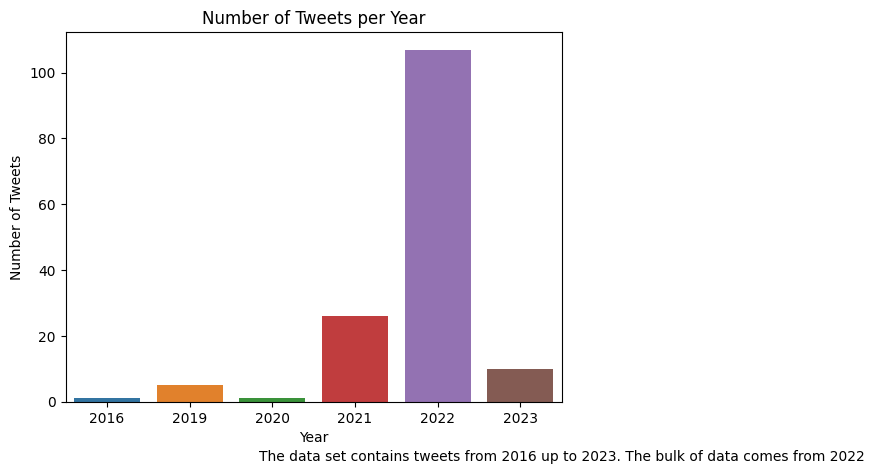

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=TSA, x='Year')
plt.xlabel('Year')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets per Year')

caption = 'The data set contains tweets from 2016 up to 2023. The bulk of data comes from 2022'
plt.text(1, -0.15, caption, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)

Consider tweets from the election year only. Binning the tweets per month.

Text(2, -0.15, 'Month 2,3, and 4 shows the most number of tweets. This is within 90 days leading up to the election (May 9), which is exactly the campaign period for the presidential elections.')

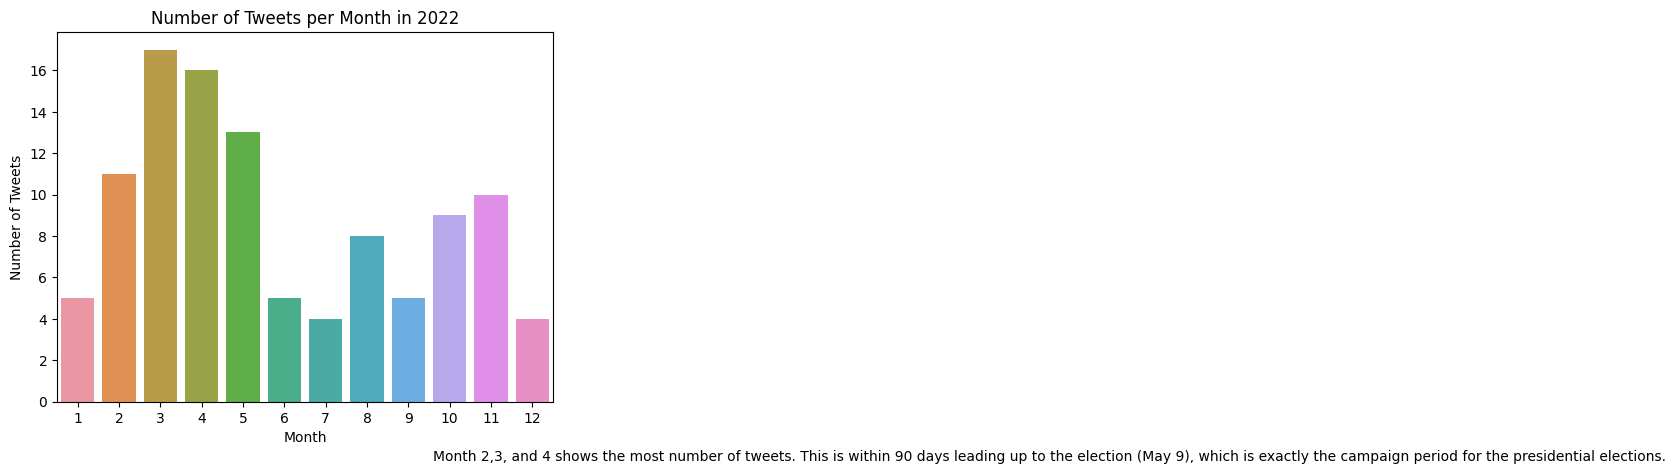

In [ ]:
election_year = 2022
monthly_2022 = TSA[TSA['Year'] == election_year]

sns.countplot(data=monthly_2022, x='Month')
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets per Month in 2022')

caption = 'Month 2,3, and 4 shows the most number of tweets. This is within 90 days leading up to the election (May 9), which is exactly the campaign period for the presidential elections.'
plt.text(2, -0.15, caption, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)

Obtain all tweets that were made during the 90 day campaign period. These are tweets between February, March, and April

In [ ]:
campaign_period_months = [2,3,4]
cpm = monthly_2022[monthly_2022['Month'].isin(campaign_period_months)]
cpm

,Tweet,Date,Year,Month,Day,Engagements,Account Type
3,xian gaza 're sure stole know 're sure testify...,2022-03-28 22:35:00,2022,3,28,6,Anonymous
4,n't tackle 9th become false witness thy neighb...,2022-03-15 11:31:00,2022,3,15,78,Identified
6,"marcos proven , evidence leni well proven evid...",2022-04-01 19:06:00,2022,4,1,3,Anonymous
8,'s marcos tried philippines opposition evidenc...,2022-04-22 22:05:00,2022,4,22,0,Anonymous
10,rollingonthefloorlaughingfacewithtearsofjoyrol...,2022-03-31 07:21:00,2022,3,31,0,Identified
14,lol 's court appeals dismissed cases Marcos wi...,2022-03-07 23:06:00,2022,3,7,0,Anonymous
15,"gwr good , mind , fooled decades antimarcos ev...",2022-03-15 05:51:00,2022,3,15,0,Anonymous
19,kapamilya2022 nine19914 evidence theft saying ...,2022-03-27 17:34:00,2022,3,27,7,Identified
21,one called thief none marcos family arrested e...,2022-04-05 17:24:00,2022,4,5,0,Anonymous
22,proof marcos thieves 3 decades accusing eviden...,2022-03-28 21:27:00,2022,3,28,25,Anonymous


Identify how many of the tweets made during the campaign period were from anonymous accounts.

Text(0.5, -0.15, 'The plot shows that 35 anonymous tweets were made during the campaign period')

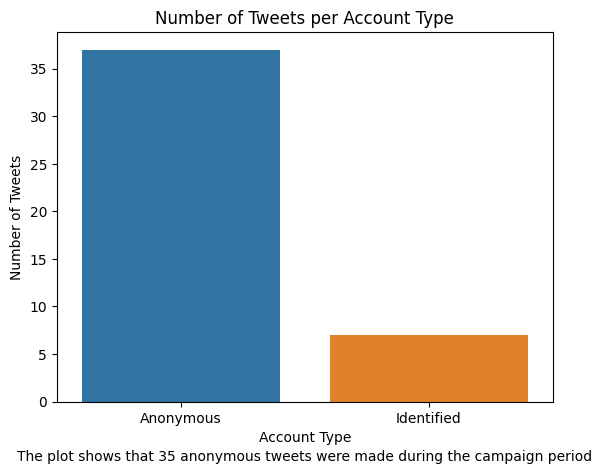

In [ ]:
sns.countplot(data=cpm, x='Account Type')
plt.xlabel('Account Type')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets per Account Type')

caption = 'The plot shows that 35 anonymous tweets were made during the campaign period'
plt.text(0.5, -0.15, caption, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)

Plot the number of engagements per month in the year 2022.

Text(0.5, -0.15, 'The plot shows the total engagements of the tweets made per month .')

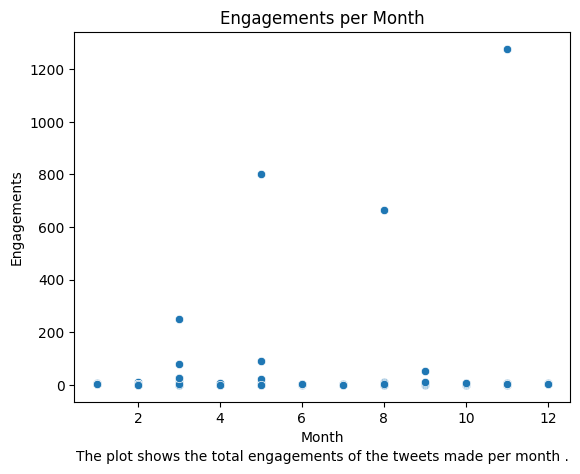

In [ ]:
sns.scatterplot(data=monthly_2022, x='Month', y='Engagements')
plt.xlabel('Month')
plt.ylabel('Engagements')
plt.title('Engagements per Month')

caption = 'The plot shows the total engagements of the tweets made per month .'
plt.text(0.5, -0.15, caption, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)

Get the average engagements per month.

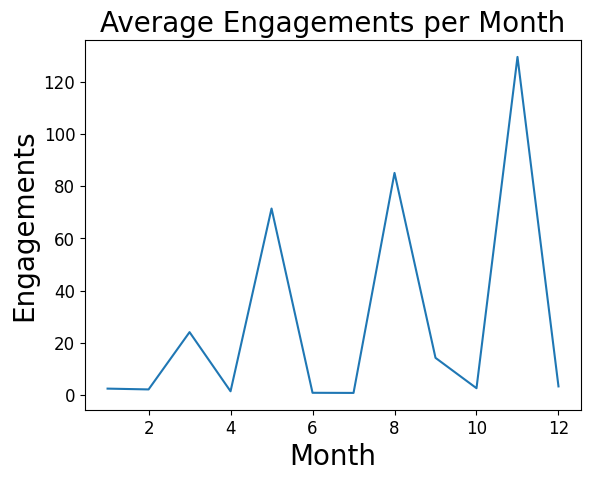

In [ ]:
monthly_avg = monthly_2022.groupby(['Month'])['Engagements'].mean().reset_index()
sns.lineplot(data=monthly_avg, x='Month', y='Engagements')
plt.xlabel('Month', fontsize=20)
plt.ylabel('Engagements', fontsize=20)
plt.title('Average Engagements per Month', fontsize=20)

plt.tick_params(axis='x', labelsize=12)  # Adjust the fontsize as needed
plt.tick_params(axis='y', labelsize=12)  # Adjust the fontsize as needed

#caption = 'This plot shows the average engagement per tweet made during the month.'
#plt.text(0.5, -0.15, caption, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)

# **Visualization**(other plots)

Create a new dataframe for visualization of plots other than Time Series Analysis.

In [ ]:
other_plots = pd.DataFrame({'Tweet': texts_tok, 'Account Type': data['Account type'], 'Engagements': NewData['Engagements']})
other_plots


,Tweet,Account Type,Engagements
0,"links fake websites , 's proof marcos never im...",Identified,1
1,psdbm—pharmally issue like marcos illgotten we...,Identified,120
2,martial victims invented ca n't proven victims...,Anonymous,89
3,xian gaza 're sure stole know 're sure testify...,Anonymous,6
4,n't tackle 9th become false witness thy neighb...,Identified,78
...,...,...,...
145,darline69977700 daughterlong bashgita 61i1690 ...,Anonymous,2
146,iantianchant avingrcga ildatalk also consider ...,Anonymous,0
147,michaelallan nine19914 u nasty keep accusing b...,Anonymous,8
148,"good accuse thief evidence shown , angry bbm e...",Anonymous,0


Compare the number of engagements for tweets made in the campaign period between anonymous(unknown) and verified(known) accounts

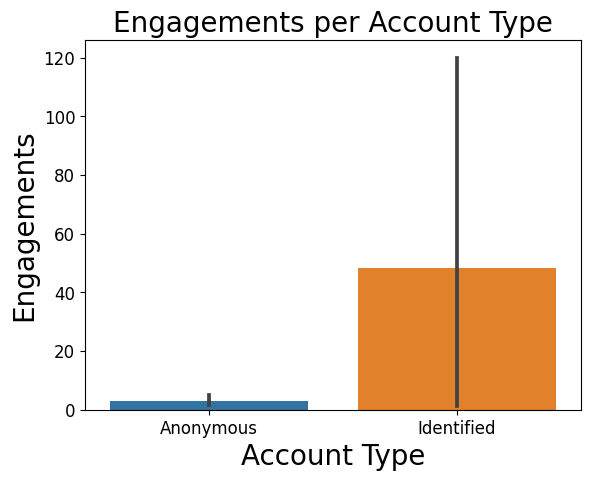

In [ ]:
sns.barplot(data=cpm, x='Account Type', y='Engagements')
plt.xlabel('Account Type', fontsize=20)
plt.ylabel('Engagements', fontsize=20)
plt.title('Engagements per Account Type', fontsize=20)

plt.tick_params(axis='x', labelsize=12)  # Adjust the fontsize as needed
plt.tick_params(axis='y', labelsize=12)  # Adjust the fontsize as needed

#caption = 'This plot shows the total number of engagements per account type for all tweets made during the campaign period.'
#plt.text(0.5, -0.15, caption, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)

Generate a new dataframe containing the account type and number of engagements. Convert the account type to Identified = 1, and Anonymous = 0.
Plot a heatmap for the correlation matrix.

Text(0.5, 1.0, 'Correlation Matrix for Account Type and Engagements')

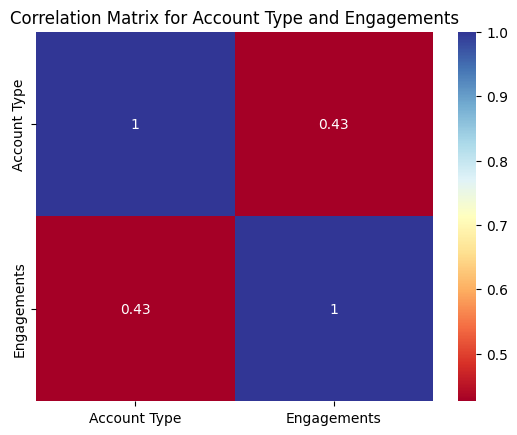

In [ ]:
cpm_at_e = cpm[['Account Type', 'Engagements']]
cpm_at_e = cpm_at_e.replace('Identified',1)
cpm_at_e = cpm_at_e.replace('Anonymous',0)
corr_matrix = cpm_at_e.corr()
sns.heatmap(corr_matrix, annot=True, cmap="RdYlBu")
plt.title("Correlation Matrix for Account Type and Engagements")